In [1]:
!wandb login

wandb: Currently logged in as: s-li2022 (sli2024). Use `wandb login --relogin` to force relogin


In [2]:
import os, gc, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa

from tqdm.notebook import tqdm
from glob import glob

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchaudio.compliance import kaldi
from torchaudio.functional import resample

import transformers
from transformers import ASTConfig, ASTFeatureExtractor, ASTModel

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_auc_score

from time import time

import timm

import wandb

In [3]:
def get_logger(log_file='log.txt'):
    import logging
    import sys
    
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    formatter = logging.Formatter('%(message)s')
    # Logging to file
    file_handler = logging.FileHandler(log_file)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    # Logging to console
    ch = logging.StreamHandler(sys.stdout)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
    
    return logger

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def wandb_init(project_name, run_name, config):
    config_dict = {
        k: v for k, v in config.__dict__.items() if not k.startswith('_') and not callable(v) and k != 'copy'
    }
    run = wandb.init(project=project_name, name=run_name, config=config_dict)
    return run

In [19]:
DRIVE_FOLDER = "." #"/content/drive/MyDrive/Colab Notebooks"
KEEP_COLS = ['category_number', 'common_name', 'audio_length', 'type', 'remarks', 'quality', 'scientific_name', 'mp3_link', 'region']

class Config:
    dataset_dir = f"{DRIVE_FOLDER}/Audio_XenoCanto"
    labels_list = f"{DRIVE_FOLDER}/xeno_labels.csv"
    model_name = "BirdAudioMAE_Baseline"
    backbone_name = "hf_hub:gaunernst/vit_base_patch16_1024_128.audiomae_as2m"
    n_classes = 728 # number of classes in the dataset
    audio_sr = 16000 #Hz
    segment_length = 10  #s
    fft_window = 0.025 #s
    hop_window_length = 0.01 #s
    n_mels = 128
    low_cut = 1000 #Hz
    high_cut = 8000 #Hz
    top_db = 100
    batch_size = 8
    num_workers = 0
    n_splits = 5
    log_dir = f"{DRIVE_FOLDER}/training_logs"
    max_lr = 1e-5
    epochs = 5
    weight_decay = 0.01
    lr_final_div = 1000
    amp = True
    grad_accum_steps = 1
    max_grad_norm = 1e7
    print_epoch_freq = 1
    print_freq = 200
    random_seed = 2046
    
    @classmethod
    def copy(cls):
        new_class = type('CustomConfig', (cls,), {k: v for k, v in cls.__dict__.items() if not k.startswith('__') and not callable(v)})
        return new_class
    
config = Config.copy()

if not os.path.exists(config.log_dir):
    os.makedirs(config.log_dir)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed_everything(config.random_seed)

In [5]:
df_audio_meta = pd.read_csv(f"{config.dataset_dir}/metadata.csv", nrows=None)
df_audio_meta = df_audio_meta.dropna().reset_index(drop=True)

# Filter out files that do not exist
df_audio_meta['file_exists'] = df_audio_meta['file_name'].apply(lambda x: os.path.exists(f"{config.dataset_dir}/{x}"))
df_audio_meta = df_audio_meta[df_audio_meta['file_exists']].reset_index(drop=True)

# parse scientific names
df_audio_meta['scientific_name'] = df_audio_meta['scientific_name'].apply(lambda x: "_".join(x.split(" ")))

# drop species with less than 2 samples
class_counts = df_audio_meta['scientific_name'].value_counts()
print(f"Number of classes with less than 2 samples: {len(class_counts[class_counts < 2])}")

df_audio_meta = df_audio_meta[df_audio_meta['scientific_name'].isin(class_counts[class_counts > 1].index)].copy().reset_index(drop=True)

# encode scientific names to label ids
label_ids_list = df_audio_meta['scientific_name'].unique().tolist()
label_ids_list.sort()
label_to_id = {label: i for i, label in enumerate(label_ids_list)}
df_audio_meta['species_id'] = df_audio_meta['scientific_name'].map(label_to_id)

#save the label_to_id mapping
label_to_id_df = pd.DataFrame(label_to_id.items(), columns=['scientific_name', 'species_id'])
label_to_id_df.to_csv(f"{config.log_dir}/{config.model_name}_label_map.csv", index=False)

# drop samples with no labels
df_audio_meta.dropna(subset=['species_id'], inplace=True)
df_audio_meta.reset_index(drop=True, inplace=True)
df_audio_meta['species_id'] = df_audio_meta['species_id'].astype(int)

print(f"Number of classes in dataset: {df_audio_meta['species_id'].nunique()}")
print(f'Number of samples:', len(df_audio_meta))

# save the number of classes in the config
config.n_classes = df_audio_meta['species_id'].nunique()

df_audio_meta.head(5)

Number of classes with less than 2 samples: 72
Number of classes in dataset: 728
Number of samples: 11171


,file_name,category_number,common_name,audio_length,type,remarks,quality,mp3_link,scientific_name,region,file_exists,species_id
0,data/XC228210-Blue-crowned_Manakin_B_9369_0.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,329
1,data/XC228210-Blue-crowned_Manakin_B_9369_1.wav,XC228210,Blue-crowned Manakin,0:20,call,ID certainty 80%. (Archiv. tape 393 side A tra...,B,//xeno-canto.org/sounds/uploaded/OOECIWCSWV/XC...,Lepidothrix_coronata,amazonas,True,329
2,data/XC200163-PIPCOR03_0.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329
3,data/XC200163-PIPCOR03_1.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329
4,data/XC200163-PIPCOR03_2.wav,XC200163,Blue-crowned Manakin,0:42,"call, song","left bank of rio Negro - terra firme forest, w...",C,//xeno-canto.org/sounds/uploaded/DGVLLRYDXS/XC...,Lepidothrix_coronata,amazonas,True,329


In [6]:
# check if all species in greater_manaus are in amazonas
greater_manaus = df_audio_meta[df_audio_meta['region'] == 'greater_manaus']
amazonas = df_audio_meta[df_audio_meta['region'] == 'amazonas']

print('Number of species in greater_manaus:', len(greater_manaus['scientific_name'].unique()))
print('Number of species in amazonas:', len(amazonas['scientific_name'].unique()))

shared_species = [x for x in greater_manaus['scientific_name'].unique().tolist() if x in amazonas['scientific_name'].unique().tolist()]

print('Number of species in both regions:', len(shared_species))

Number of species in greater_manaus: 197
Number of species in amazonas: 724
Number of species in both regions: 193


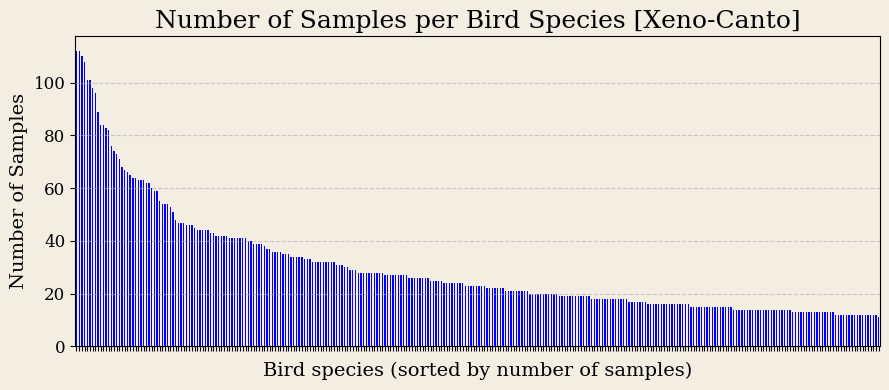

In [7]:
# calculate the number of samples per class and weights for focal loss
class_counts = df_audio_meta['species_id'].value_counts().sort_index()
class_weights = 1 / class_counts

# plot the distribution of the number of samples per class
fig, ax = plt.subplots(figsize=(9, 4))

class_counts_sorted = class_counts.sort_values(ascending=False)
class_counts.sort_values(ascending=False)[0:300].plot(ax=ax, kind='bar', color='blue')
ax.set_xticklabels([])
ax.tick_params(axis='y', labelcolor='black', labelsize=12, labelfontfamily='serif')
ax.set_xlabel('Bird species (sorted by number of samples)', fontsize=14, fontfamily='serif')
ax.set_ylabel('Number of Samples', fontsize=14, fontfamily='serif')
ax.set_title('Number of Samples per Bird Species [Xeno-Canto]', fontsize=18, fontfamily='serif')
ax.set_facecolor('#f3ede2')
fig.set_facecolor('#f3ede2')
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [8]:
class BirdAudioMAEDataset(Dataset):
    
    def __init__(self, df_audio_meta, config):
        self.df_audio_meta = df_audio_meta
        self.config = config
        self.global_mean = -4.2677393
        self.global_std = 4.5689974
    
    def __len__(self):
        return len(self.df_audio_meta)
    
    def preprocess(self, x: torch.Tensor):
        x = x - x.mean()
        melspec = kaldi.fbank(x.unsqueeze(0), htk_compat=True, window_type="hanning", num_mel_bins=128)
        if melspec.shape[0] < 1024:
            melspec = F.pad(melspec, (0, 0, 0, 1024 - melspec.shape[0]))
        else:
            melspec = melspec[:1024]
        melspec = (melspec - self.global_mean) / (self.global_std * 2)
        return melspec

    def __getitem__(self, idx):
        row = self.df_audio_meta.iloc[idx]
        audio_path = f"{self.config.dataset_dir}/{row['file_name']}"
         # load audio file
        audio_arr, sr = librosa.load(audio_path, sr=self.config.audio_sr) 
        # get the spectrogram
        spec = self.preprocess(torch.tensor(audio_arr))
        return spec, row['species_id']

def collate_fn(batch):
    inputs = [x[0] for x in batch]
    targets = [x[1] for x in batch]
    data_dict = {
        "input_ids": torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0),
        "labels": torch.tensor(targets)
    }
    return data_dict

torch.Size([2, 1024, 128]) torch.Size([2])


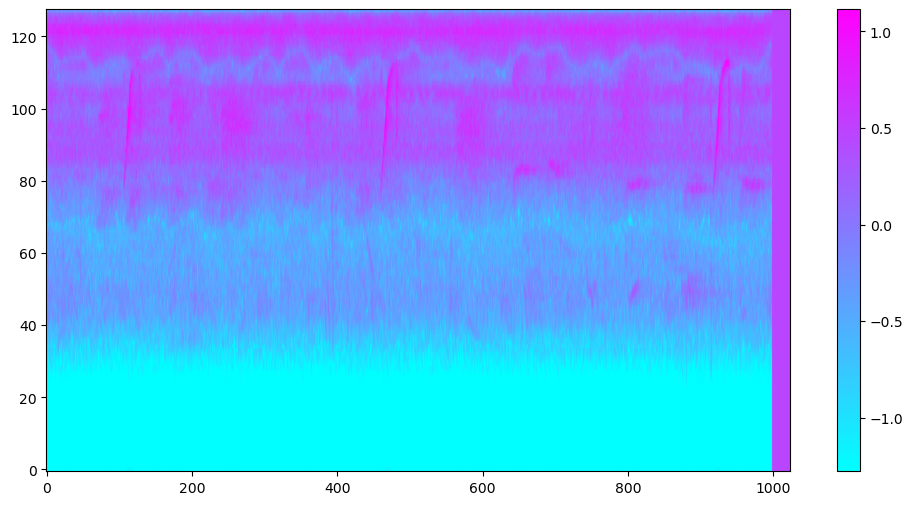

In [10]:
# test the dataset
dataset = BirdAudioMAEDataset(df_audio_meta, config)
dataloader = DataLoader(dataset, batch_size=2, collate_fn=collate_fn, num_workers=config.num_workers)

for data in dataloader:
    print(data['input_ids'].shape, data['labels'].shape)
    break

plt.figure(figsize=(12, 6))
plt.imshow(data['input_ids'][0].numpy().T, aspect='auto', origin='lower', cmap='cool')
plt.colorbar()
plt.show()

In [13]:
import json, requests

TAG = "gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k"
MODEL = timm.create_model(f"hf_hub:{TAG}", pretrained=True).eval()

LABEL_URL = "https://huggingface.co/datasets/huggingface/label-files/raw/main/audioset-id2label.json"
AUDIOSET_LABELS = list(json.loads(requests.get(LABEL_URL).content).values())

In [18]:
logits = MODEL(data['input_ids'].unsqueeze(1))#.squeeze(0)

topk_probs, topk_classes = logits.sigmoid().topk(10)

print("Top 10 classes and probabilities:")

for batch_id in range(len(data['input_ids'])):
    topk_probs, topk_classes = logits[batch_id].sigmoid().topk(10)
    preds = [[AUDIOSET_LABELS[cls], prob.item() * 100] for cls, prob in zip(topk_classes, topk_probs)]
    
    print(f"Sample {batch_id + 1}:")
    for pred in preds:
        print(f"{pred[0]}: {pred[1]:.2f}%")
    
    print()

Top 10 classes and probabilities:
Sample 1:
Bird: 36.07%
Bird vocalization, bird call, bird song: 33.00%
Insect: 31.44%
Cricket: 25.27%
Chirp, tweet: 18.85%
Outside, rural or natural: 9.98%
Animal: 9.47%
Environmental noise: 9.04%
Frog: 4.90%
Owl: 3.39%

Sample 2:
Bird: 27.69%
Bird vocalization, bird call, bird song: 27.68%
Animal: 20.19%
Outside, rural or natural: 15.69%
Insect: 13.53%
Chirp, tweet: 12.27%
Cricket: 9.58%
Environmental noise: 8.96%
Owl: 7.42%
Snake: 7.03%



In [10]:
class BirdAudioMAE(nn.Module):
    
    def __init__(self, backbone_name, n_classes, n_mlp_layers=1, activation='silu'):
        super(BirdAudioMAE, self).__init__()
        
        # pre-trained backbone
        self.feature_encoder = timm.create_model(backbone_name, pretrained=True, num_classes=0)
        self.hidden_size = self.feature_encoder.embed_dim
        
        # self.feature_encoder = nn.Sequential(*list(self.backbone.children())[:-2])
        
        # set activation functions
        if activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'silu':
            self.activation = nn.SiLU()
        elif activation == 'gelu':
            self.activation = nn.GELU()
        else:
            raise ValueError("Unsupported activation function. Choose 'relu', 'silu' or 'gelu'.")
        
        # define MLP layers with activation
        layers = []
        for _ in range(n_mlp_layers):
            layers.append(nn.Linear(self.hidden_size, self.hidden_size))
            layers.append(self.activation)
        layers.append(nn.Linear(self.hidden_size, n_classes))
        self.mlp = nn.Sequential(*layers)
        
    def forward(self, spectrogram):
        # spectrogram: (batch_size, n_frames, n_mels)
        # output: (batch_size, n_classes)
        
        encoder_output = self.feature_encoder(spectrogram.unsqueeze(1))
        logits = self.mlp(encoder_output)
        
        return {'logits': logits}


In [11]:
# test the model / loss_fn / eval_fn using dataloader

bs_dataset = BirdAudioMAEDataset(df_audio_meta, config)
bs_dataloader = DataLoader(bs_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

print(config.backbone_name)

bird_audio_mae_model = BirdAudioMAE(config.backbone_name, config.n_classes, n_mlp_layers=1, activation='silu')

for batch in bs_dataloader:
    
    input_ids = batch['input_ids']
    labels = batch['labels']
    
    output = bird_audio_mae_model(input_ids)
    logits = output['logits']
    
    print(f"Shape of input_ids: {input_ids.shape}")
    print(f"Shape of labels: {labels.shape}")
    print(f"Shape of logits: {logits.shape}")
    # print(f"Loss: {loss.item()}, Eval Score: {eval_score}")
    
    break

hf_hub:gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k
Shape of input_ids: torch.Size([8, 1024, 128])
Shape of labels: torch.Size([8])
Shape of logits: torch.Size([8, 728])


In [12]:
# define loss_fn and eval_fn
class FocalLoss(nn.Module):
    
    def __init__(self, gamma=0, alpha=None, reduction='mean', device=DEVICE):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        
        if isinstance(alpha, (float, int, )): 
            self.alpha = torch.Tensor([alpha, 1-alpha])
        elif isinstance(alpha, (list, np.ndarray)): 
            self.alpha = torch.tensor(alpha, dtype=torch.float32, device=device)
        else:
            raise TypeError('Invalid alpha type')
        
        self.ce_loss = nn.CrossEntropyLoss(weight=self.alpha, reduction='none')

    def forward(self, logits, targets):
        ce_loss = self.ce_loss(logits, targets) # nn.CrossEntropyLoss already applies log_softmax
        pt = torch.exp(-ce_loss) # CE = -log(p_t) -> p_t = exp(-CE)
        
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        return_method = {
            'mean': torch.mean,
            'sum': torch.sum,
            'none': lambda x: x
        }
        
        return return_method[self.reduction](focal_loss)
        
        
# eval_fn
class ROC_AUC_Score(nn.Module):
    
    def __init__(self, config, average='macro', multi_class='ovo'):
        super(ROC_AUC_Score, self).__init__()
        self.num_classes = config.n_classes
        self.average = average
        self.multi_class = multi_class  # 'ovo' (one-vs-one) or 'ovr' (one-vs-rest)
        self.label_ids = np.arange(self.num_classes)

    def forward(self, logits, targets):
        # logits: (batch_size, n_classes)
        # targets: (batch_size,) with integer labels
        
        # Apply softmax to convert logits to probabilities
        probas = torch.exp(F.log_softmax(logits, dim=1))

        # Detach and move to CPU for sklearn compatibility
        probas = probas.detach().cpu().numpy()
        targets = targets.detach().cpu().numpy()
        
        df_scores = pd.DataFrame(probas, columns=self.label_ids)
        df_scores['target'] = targets
        
        # remove samples with classes which is predeicted as 0 in all samples
        unscored_cols = df_scores.columns[df_scores.sum(axis=0) == 0]
        rows_to_remove = df_scores['target'].isin(unscored_cols)
        df_scores = df_scores[~rows_to_remove]
        
        eval_score = roc_auc_score(
            y_true=df_scores['target'].values,
            y_score=df_scores[self.label_ids].values,
            average=self.average, 
            multi_class=self.multi_class,
            labels=self.label_ids
        )
        
        return eval_score

In [13]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.value = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.value = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
        
class Trainer:

    def __init__(self, model, loss_fn, evel_fn, logger, config, is_higher_better=True):
        '''
        model: nn.Module
        loss_fn: loss function
        evel_fn: evaluation function
        logger: logger
        config: Config
        is_higher_better: bool (default: True) whether higher evaluation score is better
        '''

        self.model = model
        self.logger = logger
        self.config = config
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.loss_fn = loss_fn
        self.loss_fn.to(self.device)
        
        self.eval_fn = evel_fn
        self.is_higher_better = is_higher_better
        
    def train(self, train_loader, valid_loader, print_epoch_freq=50, from_checkpoint=None, use_tqdm=True):

        self.optimizer = AdamW(self.model.parameters(), lr=1e-3, weight_decay=self.config.weight_decay)

        self.scheduler = OneCycleLR(
            self.optimizer,
            max_lr=self.config.max_lr,
            epochs=self.config.epochs,
            steps_per_epoch=len(train_loader),
            pct_start=0.1,
            anneal_strategy="cos",
            final_div_factor=self.config.lr_final_div,
        )

        if from_checkpoint is not None:
            self.model.load_state_dict(torch.load(from_checkpoint, map_location=self.device))

        self.model.to(self.device)
        best_weights, best_preds, best_loss = None, None, float("-inf") if self.is_higher_better else float("inf")
        loss_records = {"train": [], "valid": []}
        
        if use_tqdm:
            pbar = tqdm(range(self.config.epochs), total=self.config.epochs, unit="epoch", leave=True, desc="Training Progress")
        else:
            pbar = range(self.config.epochs)
            
        for epoch in pbar:
            start_epoch = time()

            train_loss, _ = self._train_or_valid_epoch(epoch, train_loader, is_train=True, use_tqdm=use_tqdm)
            valid_loss, valid_preds = self._train_or_valid_epoch(epoch, valid_loader, is_train=False, use_tqdm=use_tqdm)
            
            loss_records["train"].append(train_loss)
            loss_records["valid"].append(valid_loss)

            elapsed = time() - start_epoch
            
            if (epoch % print_epoch_freq == 0) or (epoch == (self.config.epochs - 1)):
                self.logger.info(f"Epoch {epoch + 1} - Train Loss: {train_loss:.4f} - Valid Loss: {valid_loss:.4f} - Elapsed Time: {elapsed:.2f}s")
            
            if self.is_higher_better:
                if valid_loss > best_loss:
                    best_loss = valid_loss
                    best_weights = self.model.state_dict()
                    best_preds = valid_preds
                    self.logger.info(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")
            else:
                if valid_loss < best_loss:
                    best_loss = valid_loss
                    best_weights = self.model.state_dict()
                    best_preds = valid_preds
                    self.logger.info(f"- Epoch {epoch + 1}: Best model found with loss = {best_loss:.4f}.")

        return best_weights, best_preds, loss_records

    def _train_or_valid_epoch(self, epoch_id, dataloader, is_train=True, use_tqdm=True):

        self.model.train() if is_train else self.model.eval()
        mode = "Train" if is_train else "Valid"

        len_loader = len(dataloader)
        scaler = GradScaler(enabled=self.config.amp)
        loss_meter = AverageMeter()
        labels_record, predicts_record = [], []

        start = time()
        
        if use_tqdm:
            pbar = tqdm(enumerate(dataloader), total=len_loader, desc=mode, unit="batch")
        else:
            pbar = enumerate(dataloader)
            
        for step, data_dict in pbar:
            
            input_ids = data_dict['input_ids'].to(self.device)
            labels = data_dict['labels'].to(self.device)
            
            if is_train:
                with autocast(enabled=self.config.amp):
                    model_output = self.model(input_ids)
                    logits = model_output['logits']
                    train_loss = self.loss_fn(logits, labels)
                    
                if self.config.grad_accum_steps > 1:
                    train_loss = train_loss / self.config.grad_accum_steps
                    
                scaler.scale(train_loss).backward()
                grad_norm = torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.max_grad_norm)
                if (step + 1) % self.config.grad_accum_steps == 0:
                    scaler.step(self.optimizer)
                    scaler.update()
                    self.optimizer.zero_grad()
                    self.scheduler.step()
                    
                loss_meter.update(train_loss.item())
                
            else:
                with torch.no_grad():
                    model_output = self.model(input_ids)
                    logits = model_output['logits']
                    valid_loss = self.loss_fn(logits, labels)

                if self.config.grad_accum_steps > 1:
                    valid_loss = valid_loss / self.config.grad_accum_steps
                    
                loss_meter.update(valid_loss.item())
                
                predicts_record.append(logits)
                labels_record.append(labels)
            
            end = time()
            
            if self.config.print_freq:
                if (step % self.config.print_freq == 0) or (step == (len_loader - 1)):
                    lr = self.scheduler.get_last_lr()[0]
                    info = f"Epoch {epoch_id + 1} [{step}/{len_loader}] | {mode} "
                    
                    if is_train:
                        info += f"Loss: {loss_meter.avg:.4f} Grad: {grad_norm:.4f} LR: {lr:.4e}"
                    else:
                        info += f"Loss: {loss_meter.avg:.4f}"

                    info += f" | Elapse: {end - start:.2f}s"
                    self.logger.info(info)

        if is_train:
            wandb.log({
                "Train Loss": loss_meter.avg, 
                "Learning Rate": self.scheduler.get_last_lr()[0],
                "Gradient Norm": grad_norm,
                "Epoch": epoch_id + 1
            })
            return loss_meter.avg, None
        else:
            eval_loss = self.eval_fn(
                torch.cat(predicts_record).cpu(),
                torch.cat(labels_record).cpu()
                )
            wandb.log({
                "Valid Loss": loss_meter.avg,
                "Eval Score": eval_loss,
                "Epoch": epoch_id + 1
            })
            predicts_record = np.concatenate([p.cpu().detach().numpy() for p in predicts_record], axis=0)
            return eval_loss, predicts_record


In [14]:
def plot_loss_record(loss_history, final_loss, start_at=0, save_to=None):
    
    fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
    ax2 = ax1.twinx()
    for i, loss in enumerate(loss_history):
        ax1.plot(np.arange(start_at, len(loss['train'])), loss['train'][start_at:], "-",   label=f'Train_{i}')
        ax2.plot(np.arange(start_at, len(loss['valid'])), loss['valid'][start_at:], ".--", label=f'Valid_{i}')
        
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Train Loss")
    ax2.set_ylabel("Valid Loss (Dashed)")
    ax1.set_title(f"Final Eval-Loss: {final_loss:.4f}")
    ax1.legend(loc='lower left', bbox_to_anchor=[1.15, 0])
    ax2.legend(loc='upper left', bbox_to_anchor=[1.15, 1])
    
    if save_to:
        plt.savefig(save_to)
    
    fig.tight_layout()
    plt.show()

In [15]:
skf = StratifiedKFold(n_splits=config.n_splits, shuffle=False)
df_audio_meta['fold'] = 0

for fold, (train_index, valid_index) in enumerate(skf.split(df_audio_meta, df_audio_meta['species_id'])):
    df_audio_meta.loc[valid_index, 'fold'] = fold

/home/shiyi/miniconda3/envs/kaggle/lib/python3.11/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [16]:
loss_fn = FocalLoss(gamma=2, alpha=class_weights.values, reduction='mean', device='cpu')
eval_fn = ROC_AUC_Score(config, average='macro', multi_class='ovo')

oof, loss_history = pd.DataFrame(), []

logger = get_logger(log_file=f"{config.log_dir}/{config.model_name}_training.log")

# log TRAIN_CONFIG
logger.info(f"{'#'*35} TRAIN_CONFIG {'#'*35}")
for k, v in config.__dict__.items():
    if '__' not in k:
        logger.info(f"{k}: {v}")

logger.info(f"{'#'*80}")

################################### TRAIN_CONFIG ###################################
dataset_dir: ./Audio_XenoCanto
labels_list: ./xeno_labels.csv
model_name: BirdAudioMAE_Baseline
backbone_name: hf_hub:gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k
n_classes: 728
audio_sr: 16000
segment_length: 10
fft_window: 0.025
hop_window_length: 0.01
n_mels: 128
low_cut: 1000
high_cut: 8000
top_db: 100
batch_size: 8
num_workers: 0
n_splits: 5
log_dir: ./training_logs
max_lr: 1e-05
epochs: 5
weight_decay: 0.01
lr_final_div: 1000
amp: True
grad_accum_steps: 1
max_grad_norm: 10000000.0
print_epoch_freq: 1
print_freq: 200
random_seed: 2046
copy: <classmethod(<function Config.copy at 0x7f1294e09800>)>
################################################################################


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: s-li2022 (sli2024). Use `wandb login --relogin` to force relogin


Loading pretrained weights from Hugging Face hub (gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k)
Converted input conv patch_embed.proj pretrained weights from 3 to 1 channel(s)


Training Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train:   0%|          | 0/1117 [00:00<?, ?batch/s]

Epoch 1 [0/1117] | Train Loss: 0.3995 Grad: 90400.9297 LR: 4.0008e-07 | Elapse: 0.92s
Epoch 1 [200/1117] | Train Loss: 0.2296 Grad: 10885.3916 LR: 3.1636e-06 | Elapse: 23.19s
Epoch 1 [400/1117] | Train Loss: 0.2182 Grad: 113325.3906 LR: 8.2513e-06 | Elapse: 45.58s
Epoch 1 [600/1117] | Train Loss: 0.1988 Grad: 97.7399 LR: 9.9982e-06 | Elapse: 68.07s
Epoch 1 [800/1117] | Train Loss: 0.1828 Grad: 5777.2119 LR: 9.9422e-06 | Elapse: 90.72s
Epoch 1 [1000/1117] | Train Loss: 0.1773 Grad: 1124.6376 LR: 9.8091e-06 | Elapse: 113.49s
Epoch 1 [1116/1117] | Train Loss: 0.1669 Grad: 26771.7324 LR: 9.6974e-06 | Elapse: 126.75s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 1 [0/280] | Valid Loss: 0.4008 | Elapse: 0.14s
Epoch 1 [200/280] | Valid Loss: 0.1542 | Elapse: 18.52s
Epoch 1 [279/280] | Valid Loss: 0.1582 | Elapse: 25.76s
Epoch 1 - Train Loss: 0.1669 - Valid Loss: 0.5431 - Elapsed Time: 230.81s
- Epoch 1: Best model found with loss = 0.5431.


Train:   0%|          | 0/1117 [00:00<?, ?batch/s]

Epoch 2 [0/1117] | Train Loss: 0.3961 Grad: 59828.6992 LR: 9.6963e-06 | Elapse: 0.14s
Epoch 2 [200/1117] | Train Loss: 0.2225 Grad: 9342.5439 LR: 9.4458e-06 | Elapse: 22.61s
Epoch 2 [400/1117] | Train Loss: 0.2117 Grad: 99543.1484 LR: 9.1258e-06 | Elapse: 45.31s
Epoch 2 [600/1117] | Train Loss: 0.1920 Grad: 118.0062 LR: 8.7415e-06 | Elapse: 68.06s
Epoch 2 [800/1117] | Train Loss: 0.1743 Grad: 7156.8145 LR: 8.2988e-06 | Elapse: 91.00s
Epoch 2 [1000/1117] | Train Loss: 0.1682 Grad: 2113.7810 LR: 7.8046e-06 | Elapse: 114.08s
Epoch 2 [1116/1117] | Train Loss: 0.1583 Grad: 37518.3398 LR: 7.4974e-06 | Elapse: 127.45s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 2 [0/280] | Valid Loss: 0.3950 | Elapse: 0.11s
Epoch 2 [200/280] | Valid Loss: 0.1517 | Elapse: 18.57s
Epoch 2 [279/280] | Valid Loss: 0.1543 | Elapse: 25.84s
Epoch 2 - Train Loss: 0.1583 - Valid Loss: 0.6023 - Elapsed Time: 230.58s
- Epoch 2: Best model found with loss = 0.6023.


Train:   0%|          | 0/1117 [00:00<?, ?batch/s]

Epoch 3 [0/1117] | Train Loss: 0.3819 Grad: 87758.3359 LR: 7.4947e-06 | Elapse: 0.14s
Epoch 3 [200/1117] | Train Loss: 0.2045 Grad: 12985.2178 LR: 6.9350e-06 | Elapse: 22.54s
Epoch 3 [400/1117] | Train Loss: 0.1972 Grad: 127246.4609 LR: 6.3451e-06 | Elapse: 45.13s
Epoch 3 [600/1117] | Train Loss: 0.1810 Grad: 155.9575 LR: 5.7342e-06 | Elapse: 67.87s
Epoch 3 [800/1117] | Train Loss: 0.1630 Grad: 7956.3188 LR: 5.1119e-06 | Elapse: 90.88s
Epoch 3 [1000/1117] | Train Loss: 0.1558 Grad: 2398.0342 LR: 4.4878e-06 | Elapse: 113.95s
Epoch 3 [1116/1117] | Train Loss: 0.1466 Grad: 40062.1562 LR: 4.1289e-06 | Elapse: 127.31s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 3 [0/280] | Valid Loss: 0.3816 | Elapse: 0.10s
Epoch 3 [200/280] | Valid Loss: 0.1477 | Elapse: 18.53s
Epoch 3 [279/280] | Valid Loss: 0.1511 | Elapse: 25.78s
Epoch 3 - Train Loss: 0.1466 - Valid Loss: 0.6325 - Elapsed Time: 229.47s
- Epoch 3: Best model found with loss = 0.6325.


Train:   0%|          | 0/1117 [00:00<?, ?batch/s]

Epoch 4 [0/1117] | Train Loss: 0.3586 Grad: 103495.5000 LR: 4.1258e-06 | Elapse: 0.14s
Epoch 4 [200/1117] | Train Loss: 0.1855 Grad: 15480.2617 LR: 3.5189e-06 | Elapse: 22.65s
Epoch 4 [400/1117] | Train Loss: 0.1804 Grad: 148420.7344 LR: 2.9351e-06 | Elapse: 45.39s
Epoch 4 [600/1117] | Train Loss: 0.1654 Grad: 188.2007 LR: 2.3835e-06 | Elapse: 68.24s
Epoch 4 [800/1117] | Train Loss: 0.1491 Grad: 8363.7832 LR: 1.8728e-06 | Elapse: 91.19s
Epoch 4 [1000/1117] | Train Loss: 0.1434 Grad: 2774.4478 LR: 1.4108e-06 | Elapse: 114.26s
Epoch 4 [1116/1117] | Train Loss: 0.1352 Grad: 44336.4883 LR: 1.1681e-06 | Elapse: 127.62s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 4 [0/280] | Valid Loss: 0.3975 | Elapse: 0.11s
Epoch 4 [200/280] | Valid Loss: 0.1463 | Elapse: 18.56s
Epoch 4 [279/280] | Valid Loss: 0.1495 | Elapse: 25.82s
Epoch 4 - Train Loss: 0.1352 - Valid Loss: 0.6509 - Elapsed Time: 232.62s
- Epoch 4: Best model found with loss = 0.6509.


Train:   0%|          | 0/1117 [00:00<?, ?batch/s]

Epoch 5 [0/1117] | Train Loss: 0.3702 Grad: 142100.9219 LR: 1.1661e-06 | Elapse: 0.14s
Epoch 5 [200/1117] | Train Loss: 0.1778 Grad: 16508.7754 LR: 7.9594e-07 | Elapse: 22.54s
Epoch 5 [400/1117] | Train Loss: 0.1750 Grad: 159464.5625 LR: 4.9138e-07 | Elapse: 45.17s
Epoch 5 [600/1117] | Train Loss: 0.1634 Grad: 234.1111 LR: 2.5717e-07 | Elapse: 67.99s
Epoch 5 [800/1117] | Train Loss: 0.1515 Grad: 8727.3867 LR: 9.6985e-08 | Elapse: 90.93s
Epoch 5 [1000/1117] | Train Loss: 0.1480 Grad: 2885.3909 LR: 1.3309e-08 | Elapse: 113.88s
Epoch 5 [1116/1117] | Train Loss: 0.1400 Grad: 43736.2305 LR: 4.0098e-10 | Elapse: 127.19s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 5 [0/280] | Valid Loss: 0.3923 | Elapse: 0.10s
Epoch 5 [200/280] | Valid Loss: 0.1461 | Elapse: 18.58s
Epoch 5 [279/280] | Valid Loss: 0.1499 | Elapse: 25.85s
Epoch 5 - Train Loss: 0.1400 - Valid Loss: 0.6503 - Elapsed Time: 232.02s


/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme

Fold 0 | Time: 20.75min | Overall Evaluation Loss: 0.6509


Epoch,▁▁▃▃▅▅▆▆██
Eval Score,▁▅▇██
Gradient Norm,▁▅▆██
Learning Rate,█▆▄▂▁
Train Loss,█▆▄▁▂
Valid Loss,█▅▂▁▁
Epoch,5
Eval Score,0.65027
Gradient Norm,43736.23047
Learning Rate,0.0
Train Loss,0.14003


Loading pretrained weights from Hugging Face hub (gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k)
Converted input conv patch_embed.proj pretrained weights from 3 to 1 channel(s)


Training Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 1 [0/1118] | Train Loss: 0.3863 Grad: 83802.0078 LR: 4.0008e-07 | Elapse: 0.14s
Epoch 1 [200/1118] | Train Loss: 0.2223 Grad: 122283.1016 LR: 3.1592e-06 | Elapse: 22.41s
Epoch 1 [400/1118] | Train Loss: 0.2131 Grad: 173.1861 LR: 8.2438e-06 | Elapse: 44.90s
Epoch 1 [600/1118] | Train Loss: 0.1969 Grad: 3727.1553 LR: 9.9982e-06 | Elapse: 67.54s
Epoch 1 [800/1118] | Train Loss: 0.1814 Grad: 1359.1461 LR: 9.9425e-06 | Elapse: 90.38s
Epoch 1 [1000/1118] | Train Loss: 0.1762 Grad: 40406.3398 LR: 9.8099e-06 | Elapse: 113.35s
Epoch 1 [1117/1118] | Train Loss: 0.1656 Grad: 30689.9668 LR: 9.6974e-06 | Elapse: 126.77s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 1 [0/280] | Valid Loss: 0.3865 | Elapse: 0.10s
Epoch 1 [200/280] | Valid Loss: 0.1649 | Elapse: 18.57s
Epoch 1 [279/280] | Valid Loss: 0.1609 | Elapse: 25.84s
Epoch 1 - Train Loss: 0.1656 - Valid Loss: 0.5335 - Elapsed Time: 234.27s
- Epoch 1: Best model found with loss = 0.5335.


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 2 [0/1118] | Train Loss: 0.3855 Grad: 52483.7812 LR: 9.6963e-06 | Elapse: 0.14s
Epoch 2 [200/1118] | Train Loss: 0.2205 Grad: 90749.1406 LR: 9.4460e-06 | Elapse: 22.54s
Epoch 2 [400/1118] | Train Loss: 0.2082 Grad: 184.1363 LR: 9.1264e-06 | Elapse: 45.16s
Epoch 2 [600/1118] | Train Loss: 0.1884 Grad: 4933.7275 LR: 8.7426e-06 | Elapse: 67.94s
Epoch 2 [800/1118] | Train Loss: 0.1722 Grad: 1831.9331 LR: 8.3005e-06 | Elapse: 90.83s
Epoch 2 [1000/1118] | Train Loss: 0.1666 Grad: 62600.4492 LR: 7.8069e-06 | Elapse: 113.84s
Epoch 2 [1117/1118] | Train Loss: 0.1567 Grad: 41895.8008 LR: 7.4974e-06 | Elapse: 127.22s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 2 [0/280] | Valid Loss: 0.3775 | Elapse: 0.11s
Epoch 2 [200/280] | Valid Loss: 0.1636 | Elapse: 18.57s
Epoch 2 [279/280] | Valid Loss: 0.1581 | Elapse: 25.83s
Epoch 2 - Train Loss: 0.1567 - Valid Loss: 0.5795 - Elapsed Time: 235.07s
- Epoch 2: Best model found with loss = 0.5795.


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 3 [0/1118] | Train Loss: 0.3711 Grad: 67646.5469 LR: 7.4947e-06 | Elapse: 0.14s
Epoch 3 [200/1118] | Train Loss: 0.2083 Grad: 136487.2344 LR: 6.9355e-06 | Elapse: 22.51s
Epoch 3 [400/1118] | Train Loss: 0.1924 Grad: 231.7101 LR: 6.3462e-06 | Elapse: 45.09s
Epoch 3 [600/1118] | Train Loss: 0.1708 Grad: 5717.2437 LR: 5.7359e-06 | Elapse: 67.89s
Epoch 3 [800/1118] | Train Loss: 0.1548 Grad: 2271.6440 LR: 5.1141e-06 | Elapse: 90.77s
Epoch 3 [1000/1118] | Train Loss: 0.1497 Grad: 72946.3359 LR: 4.4906e-06 | Elapse: 113.78s
Epoch 3 [1117/1118] | Train Loss: 0.1411 Grad: 52110.7773 LR: 4.1289e-06 | Elapse: 127.15s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 3 [0/280] | Valid Loss: 0.3723 | Elapse: 0.11s
Epoch 3 [200/280] | Valid Loss: 0.1639 | Elapse: 18.55s
Epoch 3 [279/280] | Valid Loss: 0.1564 | Elapse: 25.79s
Epoch 3 - Train Loss: 0.1411 - Valid Loss: 0.6120 - Elapsed Time: 234.81s
- Epoch 3: Best model found with loss = 0.6120.


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 4 [0/1118] | Train Loss: 0.3604 Grad: 97774.1875 LR: 4.1258e-06 | Elapse: 0.15s
Epoch 4 [200/1118] | Train Loss: 0.1896 Grad: 156262.9531 LR: 3.5195e-06 | Elapse: 22.58s
Epoch 4 [400/1118] | Train Loss: 0.1746 Grad: 256.3327 LR: 2.9361e-06 | Elapse: 45.17s
Epoch 4 [600/1118] | Train Loss: 0.1551 Grad: 6186.1582 LR: 2.3850e-06 | Elapse: 67.91s
Epoch 4 [800/1118] | Train Loss: 0.1405 Grad: 2507.2280 LR: 1.8745e-06 | Elapse: 90.81s
Epoch 4 [1000/1118] | Train Loss: 0.1366 Grad: 75235.8125 LR: 1.4128e-06 | Elapse: 113.83s
Epoch 4 [1117/1118] | Train Loss: 0.1291 Grad: 55799.8164 LR: 1.1681e-06 | Elapse: 127.21s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 4 [0/280] | Valid Loss: 0.3671 | Elapse: 0.10s
Epoch 4 [200/280] | Valid Loss: 0.1653 | Elapse: 18.56s
Epoch 4 [279/280] | Valid Loss: 0.1566 | Elapse: 25.79s
Epoch 4 - Train Loss: 0.1291 - Valid Loss: 0.6178 - Elapsed Time: 234.79s
- Epoch 4: Best model found with loss = 0.6178.


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 5 [0/1118] | Train Loss: 0.3601 Grad: 118599.2422 LR: 1.1661e-06 | Elapse: 0.14s
Epoch 5 [200/1118] | Train Loss: 0.1834 Grad: 160883.1562 LR: 7.9625e-07 | Elapse: 22.52s
Epoch 5 [400/1118] | Train Loss: 0.1706 Grad: 263.8847 LR: 4.9187e-07 | Elapse: 45.11s
Epoch 5 [600/1118] | Train Loss: 0.1528 Grad: 6263.2642 LR: 2.5771e-07 | Elapse: 67.84s
Epoch 5 [800/1118] | Train Loss: 0.1414 Grad: 2626.2375 LR: 9.7424e-08 | Elapse: 90.76s
Epoch 5 [1000/1118] | Train Loss: 0.1433 Grad: 65324.4336 LR: 1.3511e-08 | Elapse: 113.80s
Epoch 5 [1117/1118] | Train Loss: 0.1357 Grad: 63864.8281 LR: 4.0097e-10 | Elapse: 127.19s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 5 [0/280] | Valid Loss: 0.3422 | Elapse: 0.11s
Epoch 5 [200/280] | Valid Loss: 0.1521 | Elapse: 18.57s
Epoch 5 [279/280] | Valid Loss: 0.1525 | Elapse: 25.84s
Epoch 5 - Train Loss: 0.1357 - Valid Loss: 0.6617 - Elapsed Time: 234.77s
- Epoch 5: Best model found with loss = 0.6617.


/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme

Fold 1 | Time: 21.42min | Overall Evaluation Loss: 0.6206


Epoch,▁▁▃▃▅▅▆▆██
Eval Score,▁▄▅▆█
Gradient Norm,▁▃▆▆█
Learning Rate,█▆▄▂▁
Train Loss,█▆▃▁▂
Valid Loss,█▆▄▄▁
Epoch,5
Eval Score,0.66167
Gradient Norm,63864.82812
Learning Rate,0.0
Train Loss,0.13574


Loading pretrained weights from Hugging Face hub (gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k)
Converted input conv patch_embed.proj pretrained weights from 3 to 1 channel(s)


Training Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 1 [0/1118] | Train Loss: 0.0095 Grad: 3951.1865 LR: 4.0008e-07 | Elapse: 0.14s
Epoch 1 [200/1118] | Train Loss: 0.2163 Grad: 490.6070 LR: 3.1592e-06 | Elapse: 22.37s
Epoch 1 [400/1118] | Train Loss: 0.2059 Grad: 170268.4219 LR: 8.2438e-06 | Elapse: 44.80s
Epoch 1 [600/1118] | Train Loss: 0.1959 Grad: 203.3052 LR: 9.9982e-06 | Elapse: 67.38s
Epoch 1 [800/1118] | Train Loss: 0.1781 Grad: 1356.8859 LR: 9.9425e-06 | Elapse: 90.09s
Epoch 1 [1000/1118] | Train Loss: 0.1735 Grad: 2896.0449 LR: 9.8099e-06 | Elapse: 112.93s
Epoch 1 [1117/1118] | Train Loss: 0.1629 Grad: 41938.3086 LR: 9.6974e-06 | Elapse: 126.25s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 1 [0/280] | Valid Loss: 0.0017 | Elapse: 0.11s
Epoch 1 [200/280] | Valid Loss: 0.1784 | Elapse: 18.47s
Epoch 1 [279/280] | Valid Loss: 0.1667 | Elapse: 25.68s
Epoch 1 - Train Loss: 0.1629 - Valid Loss: 0.5069 - Elapsed Time: 232.64s
- Epoch 1: Best model found with loss = 0.5069.


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 2 [0/1118] | Train Loss: 0.0090 Grad: 2005.3993 LR: 9.6963e-06 | Elapse: 0.14s
Epoch 2 [200/1118] | Train Loss: 0.2146 Grad: 237.3292 LR: 9.4460e-06 | Elapse: 22.44s
Epoch 2 [400/1118] | Train Loss: 0.2037 Grad: 83483.6328 LR: 9.1264e-06 | Elapse: 44.88s
Epoch 2 [600/1118] | Train Loss: 0.1930 Grad: 106.7341 LR: 8.7426e-06 | Elapse: 67.48s
Epoch 2 [800/1118] | Train Loss: 0.1750 Grad: 937.9145 LR: 8.3005e-06 | Elapse: 90.26s
Epoch 2 [1000/1118] | Train Loss: 0.1702 Grad: 2630.5820 LR: 7.8069e-06 | Elapse: 113.18s
Epoch 2 [1117/1118] | Train Loss: 0.1598 Grad: 22480.0117 LR: 7.4974e-06 | Elapse: 126.48s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 2 [0/280] | Valid Loss: 0.0019 | Elapse: 0.10s
Epoch 2 [200/280] | Valid Loss: 0.1762 | Elapse: 18.38s
Epoch 2 [279/280] | Valid Loss: 0.1647 | Elapse: 25.57s
Epoch 2 - Train Loss: 0.1598 - Valid Loss: 0.5040 - Elapsed Time: 232.36s


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 3 [0/1118] | Train Loss: 0.0094 Grad: 1841.3789 LR: 7.4947e-06 | Elapse: 0.14s
Epoch 3 [200/1118] | Train Loss: 0.2106 Grad: 266.2804 LR: 6.9355e-06 | Elapse: 22.41s
Epoch 3 [400/1118] | Train Loss: 0.2001 Grad: 85211.2344 LR: 6.3462e-06 | Elapse: 44.82s
Epoch 3 [600/1118] | Train Loss: 0.1899 Grad: 120.8874 LR: 5.7359e-06 | Elapse: 67.39s
Epoch 3 [800/1118] | Train Loss: 0.1724 Grad: 1014.0571 LR: 5.1141e-06 | Elapse: 90.14s
Epoch 3 [1000/1118] | Train Loss: 0.1677 Grad: 2723.1299 LR: 4.4906e-06 | Elapse: 113.01s
Epoch 3 [1117/1118] | Train Loss: 0.1576 Grad: 22769.2773 LR: 4.1289e-06 | Elapse: 126.28s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 3 [0/280] | Valid Loss: 0.0021 | Elapse: 0.11s
Epoch 3 [200/280] | Valid Loss: 0.1748 | Elapse: 18.36s
Epoch 3 [279/280] | Valid Loss: 0.1635 | Elapse: 25.56s
Epoch 3 - Train Loss: 0.1576 - Valid Loss: 0.5087 - Elapsed Time: 230.74s
- Epoch 3: Best model found with loss = 0.5087.


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 4 [0/1118] | Train Loss: 0.0098 Grad: 1950.0308 LR: 4.1258e-06 | Elapse: 0.14s
Epoch 4 [200/1118] | Train Loss: 0.2083 Grad: 292.0843 LR: 3.5195e-06 | Elapse: 22.37s
Epoch 4 [400/1118] | Train Loss: 0.1982 Grad: 87330.6250 LR: 2.9361e-06 | Elapse: 44.79s
Epoch 4 [600/1118] | Train Loss: 0.1881 Grad: 131.7884 LR: 2.3850e-06 | Elapse: 67.38s
Epoch 4 [800/1118] | Train Loss: 0.1708 Grad: 1065.2107 LR: 1.8745e-06 | Elapse: 90.11s
Epoch 4 [1000/1118] | Train Loss: 0.1663 Grad: 2788.4729 LR: 1.4128e-06 | Elapse: 112.90s
Epoch 4 [1117/1118] | Train Loss: 0.1562 Grad: 23085.8184 LR: 1.1681e-06 | Elapse: 126.17s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 4 [0/280] | Valid Loss: 0.0022 | Elapse: 0.10s
Epoch 4 [200/280] | Valid Loss: 0.1741 | Elapse: 18.40s
Epoch 4 [279/280] | Valid Loss: 0.1629 | Elapse: 25.60s
Epoch 4 - Train Loss: 0.1562 - Valid Loss: 0.5073 - Elapsed Time: 231.31s


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 5 [0/1118] | Train Loss: 0.0101 Grad: 2022.8783 LR: 1.1661e-06 | Elapse: 0.14s
Epoch 5 [200/1118] | Train Loss: 0.2071 Grad: 305.2502 LR: 7.9625e-07 | Elapse: 22.41s
Epoch 5 [400/1118] | Train Loss: 0.1971 Grad: 88461.0078 LR: 4.9187e-07 | Elapse: 44.85s
Epoch 5 [600/1118] | Train Loss: 0.1872 Grad: 135.7806 LR: 2.5771e-07 | Elapse: 67.46s
Epoch 5 [800/1118] | Train Loss: 0.1700 Grad: 1082.4529 LR: 9.7424e-08 | Elapse: 90.23s
Epoch 5 [1000/1118] | Train Loss: 0.1655 Grad: 2802.9209 LR: 1.3511e-08 | Elapse: 113.13s
Epoch 5 [1117/1118] | Train Loss: 0.1555 Grad: 23158.2520 LR: 4.0097e-10 | Elapse: 126.46s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 5 [0/280] | Valid Loss: 0.0022 | Elapse: 0.11s
Epoch 5 [200/280] | Valid Loss: 0.1739 | Elapse: 18.51s
Epoch 5 [279/280] | Valid Loss: 0.1628 | Elapse: 25.74s
Epoch 5 - Train Loss: 0.1555 - Valid Loss: 0.5066 - Elapsed Time: 231.46s


/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme

Fold 2 | Time: 21.33min | Overall Evaluation Loss: 0.5739


Epoch,▁▁▃▃▅▅▆▆██
Eval Score,▅▁█▆▅
Gradient Norm,█▁▁▁▁
Learning Rate,█▆▄▂▁
Train Loss,█▅▃▂▁
Valid Loss,█▄▂▁▁
Epoch,5
Eval Score,0.50663
Gradient Norm,23158.25195
Learning Rate,0.0
Train Loss,0.15554


Loading pretrained weights from Hugging Face hub (gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k)
Converted input conv patch_embed.proj pretrained weights from 3 to 1 channel(s)


Training Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 1 [0/1118] | Train Loss: 0.0074 Grad: 3739.3579 LR: 4.0008e-07 | Elapse: 0.15s
Epoch 1 [200/1118] | Train Loss: 0.2262 Grad: 7297.6655 LR: 3.1592e-06 | Elapse: 22.46s
Epoch 1 [400/1118] | Train Loss: 0.1991 Grad: 60344.2695 LR: 8.2438e-06 | Elapse: 44.91s
Epoch 1 [600/1118] | Train Loss: 0.2000 Grad: 803.5960 LR: 9.9982e-06 | Elapse: 67.50s
Epoch 1 [800/1118] | Train Loss: 0.1794 Grad: 14373.1230 LR: 9.9425e-06 | Elapse: 90.22s
Epoch 1 [1000/1118] | Train Loss: 0.1764 Grad: 58055.1289 LR: 9.8099e-06 | Elapse: 113.20s
Epoch 1 [1117/1118] | Train Loss: 0.1657 Grad: 35630.9883 LR: 9.6974e-06 | Elapse: 126.61s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 1 [0/280] | Valid Loss: 0.0018 | Elapse: 0.11s
Epoch 1 [200/280] | Valid Loss: 0.1726 | Elapse: 18.61s
Epoch 1 [279/280] | Valid Loss: 0.1606 | Elapse: 25.91s
Epoch 1 - Train Loss: 0.1657 - Valid Loss: 0.5080 - Elapsed Time: 229.11s
- Epoch 1: Best model found with loss = 0.5080.


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 2 [0/1118] | Train Loss: 0.0085 Grad: 2772.1047 LR: 9.6963e-06 | Elapse: 0.14s
Epoch 2 [200/1118] | Train Loss: 0.2196 Grad: 4724.5649 LR: 9.4460e-06 | Elapse: 22.59s
Epoch 2 [400/1118] | Train Loss: 0.1904 Grad: 73951.5391 LR: 9.1264e-06 | Elapse: 45.21s
Epoch 2 [600/1118] | Train Loss: 0.1898 Grad: 1031.2745 LR: 8.7426e-06 | Elapse: 68.04s
Epoch 2 [800/1118] | Train Loss: 0.1701 Grad: 21432.4414 LR: 8.3005e-06 | Elapse: 90.93s
Epoch 2 [1000/1118] | Train Loss: 0.1677 Grad: 902172.5625 LR: 7.8069e-06 | Elapse: 113.95s
Epoch 2 [1117/1118] | Train Loss: 0.1577 Grad: 225110.3125 LR: 7.4974e-06 | Elapse: 127.31s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 2 [0/280] | Valid Loss: 0.0017 | Elapse: 0.10s
Epoch 2 [200/280] | Valid Loss: 0.1737 | Elapse: 18.56s
Epoch 2 [279/280] | Valid Loss: 0.1609 | Elapse: 25.82s
Epoch 2 - Train Loss: 0.1577 - Valid Loss: 0.5050 - Elapsed Time: 230.27s


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 3 [0/1118] | Train Loss: 0.0087 Grad: 3890.7788 LR: 7.4947e-06 | Elapse: 0.14s
Epoch 3 [200/1118] | Train Loss: 0.2166 Grad: 8321.0664 LR: 6.9355e-06 | Elapse: 22.55s
Epoch 3 [400/1118] | Train Loss: 0.1902 Grad: 65510.1211 LR: 6.3462e-06 | Elapse: 45.20s
Epoch 3 [600/1118] | Train Loss: 0.1916 Grad: 1199.1069 LR: 5.7359e-06 | Elapse: 67.98s
Epoch 3 [800/1118] | Train Loss: 0.1720 Grad: 4684.8101 LR: 5.1141e-06 | Elapse: 90.82s
Epoch 3 [1000/1118] | Train Loss: 0.1691 Grad: 19641.2891 LR: 4.4906e-06 | Elapse: 113.79s
Epoch 3 [1117/1118] | Train Loss: 0.1590 Grad: 11476.2256 LR: 4.1289e-06 | Elapse: 127.11s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 3 [0/280] | Valid Loss: 0.0017 | Elapse: 0.11s
Epoch 3 [200/280] | Valid Loss: 0.1727 | Elapse: 18.49s
Epoch 3 [279/280] | Valid Loss: 0.1602 | Elapse: 25.72s
Epoch 3 - Train Loss: 0.1590 - Valid Loss: 0.5093 - Elapsed Time: 229.86s
- Epoch 3: Best model found with loss = 0.5093.


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 4 [0/1118] | Train Loss: 0.0086 Grad: 1968.5505 LR: 4.1258e-06 | Elapse: 0.14s
Epoch 4 [200/1118] | Train Loss: 0.2175 Grad: 21281.1484 LR: 3.5195e-06 | Elapse: 22.53s
Epoch 4 [400/1118] | Train Loss: 0.1861 Grad: 63600.4102 LR: 2.9361e-06 | Elapse: 45.04s
Epoch 4 [600/1118] | Train Loss: 0.1866 Grad: 1397.3033 LR: 2.3850e-06 | Elapse: 67.74s
Epoch 4 [800/1118] | Train Loss: 0.1683 Grad: 6127.5493 LR: 1.8745e-06 | Elapse: 90.65s
Epoch 4 [1000/1118] | Train Loss: 0.1659 Grad: 20272.6953 LR: 1.4128e-06 | Elapse: 113.75s
Epoch 4 [1117/1118] | Train Loss: 0.1560 Grad: 11820.9346 LR: 1.1681e-06 | Elapse: 127.09s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 4 [0/280] | Valid Loss: 0.0017 | Elapse: 0.10s
Epoch 4 [200/280] | Valid Loss: 0.1718 | Elapse: 18.47s
Epoch 4 [279/280] | Valid Loss: 0.1595 | Elapse: 25.69s
Epoch 4 - Train Loss: 0.1560 - Valid Loss: 0.5060 - Elapsed Time: 232.42s


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 5 [0/1118] | Train Loss: 0.0087 Grad: 2234.9836 LR: 1.1661e-06 | Elapse: 0.14s
Epoch 5 [200/1118] | Train Loss: 0.2198 Grad: 31569.0801 LR: 7.9625e-07 | Elapse: 22.54s
Epoch 5 [400/1118] | Train Loss: 0.1926 Grad: 192526.8750 LR: 4.9187e-07 | Elapse: 45.11s
Epoch 5 [600/1118] | Train Loss: 0.1912 Grad: 848.1763 LR: 2.5771e-07 | Elapse: 67.88s
Epoch 5 [800/1118] | Train Loss: 0.1722 Grad: 83752.0156 LR: 9.7424e-08 | Elapse: 90.70s
Epoch 5 [1000/1118] | Train Loss: 0.1714 Grad: 377485.3438 LR: 1.3511e-08 | Elapse: 113.61s
Epoch 5 [1117/1118] | Train Loss: 0.1612 Grad: 111406.2266 LR: 4.0097e-10 | Elapse: 126.92s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 5 [0/280] | Valid Loss: 0.0023 | Elapse: 0.11s
Epoch 5 [200/280] | Valid Loss: 0.1656 | Elapse: 18.55s
Epoch 5 [279/280] | Valid Loss: 0.1572 | Elapse: 25.81s
Epoch 5 - Train Loss: 0.1612 - Valid Loss: 0.5141 - Elapsed Time: 229.32s
- Epoch 5: Best model found with loss = 0.5141.


/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme

Fold 3 | Time: 21.38min | Overall Evaluation Loss: 0.5514


Epoch,▁▁▃▃▅▅▆▆██
Eval Score,▃▁▄▂█
Gradient Norm,▂█▁▁▄
Learning Rate,█▆▄▂▁
Train Loss,█▂▃▁▅
Valid Loss,██▇▅▁
Epoch,5
Eval Score,0.51411
Gradient Norm,111406.22656
Learning Rate,0.0
Train Loss,0.16119


Loading pretrained weights from Hugging Face hub (gaunernst/vit_base_patch16_1024_128.audiomae_as2m_ft_as20k)
Converted input conv patch_embed.proj pretrained weights from 3 to 1 channel(s)


Training Progress:   0%|          | 0/5 [00:00<?, ?epoch/s]

Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 1 [0/1118] | Train Loss: 0.0087 Grad: 3985.6213 LR: 4.0008e-07 | Elapse: 0.14s
Epoch 1 [200/1118] | Train Loss: 0.2182 Grad: 1529.7610 LR: 3.1592e-06 | Elapse: 22.39s
Epoch 1 [400/1118] | Train Loss: 0.1807 Grad: 6699.7900 LR: 8.2438e-06 | Elapse: 44.71s
Epoch 1 [600/1118] | Train Loss: 0.1867 Grad: 42053.0273 LR: 9.9982e-06 | Elapse: 67.20s
Epoch 1 [800/1118] | Train Loss: 0.1744 Grad: 1752.4176 LR: 9.9425e-06 | Elapse: 89.84s
Epoch 1 [1000/1118] | Train Loss: 0.1651 Grad: 331.9807 LR: 9.8099e-06 | Elapse: 112.64s
Epoch 1 [1117/1118] | Train Loss: 0.1656 Grad: 32379.8047 LR: 9.6974e-06 | Elapse: 125.96s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 1 [0/280] | Valid Loss: 0.3163 | Elapse: 0.11s
Epoch 1 [200/280] | Valid Loss: 0.2016 | Elapse: 18.53s
Epoch 1 [279/280] | Valid Loss: 0.1603 | Elapse: 25.74s
Epoch 1 - Train Loss: 0.1656 - Valid Loss: 0.5491 - Elapsed Time: 231.95s
- Epoch 1: Best model found with loss = 0.5491.


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 2 [0/1118] | Train Loss: 0.0085 Grad: 3273.5898 LR: 9.6963e-06 | Elapse: 0.14s
Epoch 2 [200/1118] | Train Loss: 0.2131 Grad: 1373.8516 LR: 9.4460e-06 | Elapse: 22.46s
Epoch 2 [400/1118] | Train Loss: 0.1737 Grad: 13050.5635 LR: 9.1264e-06 | Elapse: 44.97s
Epoch 2 [600/1118] | Train Loss: 0.1768 Grad: 26469.0703 LR: 8.7426e-06 | Elapse: 67.68s
Epoch 2 [800/1118] | Train Loss: 0.1652 Grad: 926.2480 LR: 8.3005e-06 | Elapse: 90.53s
Epoch 2 [1000/1118] | Train Loss: 0.1567 Grad: 219.8156 LR: 7.8069e-06 | Elapse: 113.51s
Epoch 2 [1117/1118] | Train Loss: 0.1574 Grad: 25269.1348 LR: 7.4974e-06 | Elapse: 126.86s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 2 [0/280] | Valid Loss: 0.3118 | Elapse: 0.11s
Epoch 2 [200/280] | Valid Loss: 0.1974 | Elapse: 18.59s
Epoch 2 [279/280] | Valid Loss: 0.1570 | Elapse: 25.85s
Epoch 2 - Train Loss: 0.1574 - Valid Loss: 0.5961 - Elapsed Time: 233.05s
- Epoch 2: Best model found with loss = 0.5961.


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 3 [0/1118] | Train Loss: 0.0090 Grad: 4395.2241 LR: 7.4947e-06 | Elapse: 0.14s
Epoch 3 [200/1118] | Train Loss: 0.1989 Grad: 1872.6017 LR: 6.9355e-06 | Elapse: 22.55s
Epoch 3 [400/1118] | Train Loss: 0.1591 Grad: 8334.5283 LR: 6.3462e-06 | Elapse: 45.08s
Epoch 3 [600/1118] | Train Loss: 0.1594 Grad: 63534.3359 LR: 5.7359e-06 | Elapse: 67.78s
Epoch 3 [800/1118] | Train Loss: 0.1485 Grad: 2978.5623 LR: 5.1141e-06 | Elapse: 90.64s
Epoch 3 [1000/1118] | Train Loss: 0.1412 Grad: 744.2615 LR: 4.4906e-06 | Elapse: 113.63s
Epoch 3 [1117/1118] | Train Loss: 0.1415 Grad: 50949.2266 LR: 4.1289e-06 | Elapse: 127.02s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 3 [0/280] | Valid Loss: 0.2746 | Elapse: 0.10s
Epoch 3 [200/280] | Valid Loss: 0.1934 | Elapse: 18.53s
Epoch 3 [279/280] | Valid Loss: 0.1537 | Elapse: 25.76s
Epoch 3 - Train Loss: 0.1415 - Valid Loss: 0.6327 - Elapsed Time: 230.99s
- Epoch 3: Best model found with loss = 0.6327.


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 4 [0/1118] | Train Loss: 0.0088 Grad: 4882.2607 LR: 4.1258e-06 | Elapse: 0.14s
Epoch 4 [200/1118] | Train Loss: 0.1725 Grad: 2287.9456 LR: 3.5195e-06 | Elapse: 22.46s
Epoch 4 [400/1118] | Train Loss: 0.1389 Grad: 9455.5947 LR: 2.9361e-06 | Elapse: 45.12s
Epoch 4 [600/1118] | Train Loss: 0.1403 Grad: 53552.1836 LR: 2.3850e-06 | Elapse: 67.94s
Epoch 4 [800/1118] | Train Loss: 0.1313 Grad: 3482.8584 LR: 1.8745e-06 | Elapse: 90.79s
Epoch 4 [1000/1118] | Train Loss: 0.1256 Grad: 828.7855 LR: 1.4128e-06 | Elapse: 113.77s
Epoch 4 [1117/1118] | Train Loss: 0.1267 Grad: 61292.6953 LR: 1.1681e-06 | Elapse: 127.11s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 4 [0/280] | Valid Loss: 0.2569 | Elapse: 0.11s
Epoch 4 [200/280] | Valid Loss: 0.1908 | Elapse: 18.50s
Epoch 4 [279/280] | Valid Loss: 0.1518 | Elapse: 25.73s
Epoch 4 - Train Loss: 0.1267 - Valid Loss: 0.6491 - Elapsed Time: 232.44s
- Epoch 4: Best model found with loss = 0.6491.


Train:   0%|          | 0/1118 [00:00<?, ?batch/s]

Epoch 5 [0/1118] | Train Loss: 0.0091 Grad: 5244.1963 LR: 1.1661e-06 | Elapse: 0.14s
Epoch 5 [200/1118] | Train Loss: 0.1620 Grad: 2402.8052 LR: 7.9625e-07 | Elapse: 22.48s
Epoch 5 [400/1118] | Train Loss: 0.1318 Grad: 9599.7549 LR: 4.9187e-07 | Elapse: 44.97s
Epoch 5 [600/1118] | Train Loss: 0.1362 Grad: 57662.5781 LR: 2.5771e-07 | Elapse: 67.65s
Epoch 5 [800/1118] | Train Loss: 0.1299 Grad: 5019.4961 LR: 9.7424e-08 | Elapse: 90.47s
Epoch 5 [1000/1118] | Train Loss: 0.1275 Grad: 888.6786 LR: 1.3511e-08 | Elapse: 113.38s
Epoch 5 [1117/1118] | Train Loss: 0.1302 Grad: 58748.6406 LR: 4.0097e-10 | Elapse: 126.81s


Valid:   0%|          | 0/280 [00:00<?, ?batch/s]

Epoch 5 [0/280] | Valid Loss: 0.2898 | Elapse: 0.10s
Epoch 5 [200/280] | Valid Loss: 0.1839 | Elapse: 18.51s
Epoch 5 [279/280] | Valid Loss: 0.1465 | Elapse: 25.77s
Epoch 5 - Train Loss: 0.1302 - Valid Loss: 0.6836 - Elapsed Time: 232.36s
- Epoch 5: Best model found with loss = 0.6836.


/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_valid[prediction_columns] = best_preds
/tmp/ipykernel_1235156/3886176064.py:47: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme

Fold 4 | Time: 21.60min | Overall Evaluation Loss: 0.5700


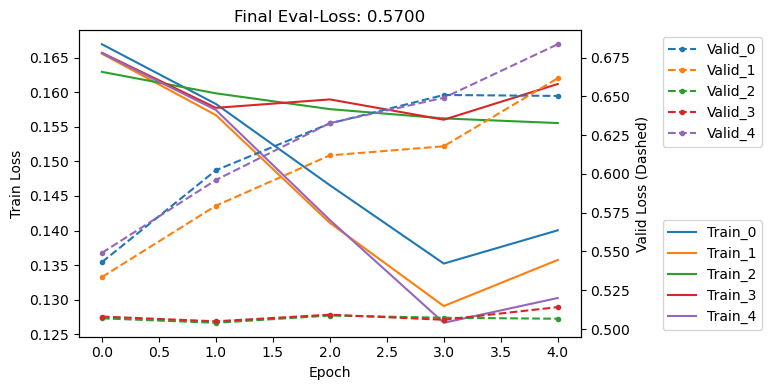

In [17]:
# --------------------------------------------------------------
# Training Loop Starts Here
# --------------------------------------------------------------
    
loader_kwargs = {
    "batch_size": config.batch_size,
    "num_workers": config.num_workers,
    "pin_memory": True,
    "shuffle": False,
    'collate_fn': collate_fn
}

prediction_columns = [f"pred_{i}" for i in range(config.n_classes)]
    
for fold_id in range(config.n_splits):
    tik = time()
    
    wandb_init(project_name=config.model_name, run_name=f"fold_{fold_id}", config=config)
    
    train_df = df_audio_meta[df_audio_meta['fold'] != fold_id].copy().reset_index(drop=True)
    valid_df = df_audio_meta[df_audio_meta['fold'] == fold_id].copy().reset_index(drop=True)
    
    train_folds = BirdAudioMAEDataset(train_df, config)
    valid_folds = BirdAudioMAEDataset(valid_df, config)
    
    train_loader = DataLoader(train_folds, **loader_kwargs)
    valid_loader = DataLoader(valid_folds, **loader_kwargs)
    
    # Initialize the model
    model = BirdAudioMAE(config.backbone_name, config.n_classes, n_mlp_layers=1, activation='silu')
    
    # Initialize the trainer
    trainer = Trainer(model, loss_fn, eval_fn, logger, config, is_higher_better=True)
    
    best_weights, best_preds, loss_records = trainer.train( 
        train_loader, 
        valid_loader, 
        print_epoch_freq=config.print_epoch_freq,
        from_checkpoint=None,
        use_tqdm=True
        )
    
    loss_history.append(loss_records)
    
    # Save oof predictions
    df_valid = pd.DataFrame({'species_id': valid_df['species_id'], 'fold': fold})
    df_preds = pd.DataFrame(best_preds, columns=prediction_columns)
    df_valid = pd.concat([df_valid, df_preds], axis=1)
    # [prediction_columns] = best_preds
    
    oof = pd.concat([oof, df_valid], axis=0).reset_index(drop=True)
    
    save_model_name = f"{config.model_name}_fold_{fold_id}"
    torch.save(best_weights, f"{config.log_dir}/{save_model_name}.pth")

    del train_folds, valid_folds, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()
    
    valid_loss_fold = eval_fn(
        torch.tensor(oof[prediction_columns].values),
        torch.tensor(oof['species_id'].values)
    )
    logger.info(f"Fold {fold_id} | Time: {(time() - tik)/60:.2f}min | Overall Evaluation Loss: {valid_loss_fold:.4f}")
        
# Summarize the final results
valid_loss = eval_fn(
    torch.tensor(oof[prediction_columns].values),
    torch.tensor(oof['species_id'].values)
)

# plot the loss history
plot_loss_record(loss_history, valid_loss, start_at=0, save_to=os.path.join(config.log_dir, f"{config.model_name}_loss.jpg"))

# Save the OOF predictions
oof.to_csv(f"{config.log_dir}/{config.model_name}_oof.csv", index=False)